In [1]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras_core as keras
from models.analytical.trapdiffusion import SingleOccupationSingleIsotope
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pathlib
from typing import Dict, Union
import yaml

Using PyTorch backend.


In [2]:
basic_model = keras.models.load_model('trained_models/basic.keras')

In [62]:
layers = []
biases = []
for layer in basic_model.layers:
    layers.append(layer.get_weights()[0])
    biases.append(layer.get_weights()[1])

In [66]:
def predict(x):
    for layer, bias in zip(layers, biases):
        x = x @ layer + bias
        x[x < 0] = 0
    return x

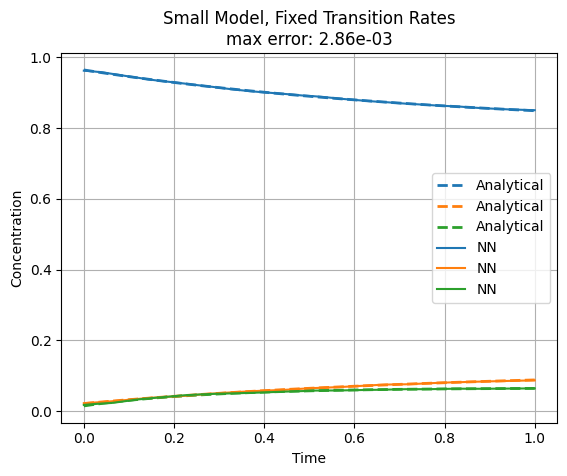

In [67]:
np.random.seed(1)
analytical_model = SingleOccupationSingleIsotope(2,1)
c_init = analytical_model.initial_values()
ts, cs = analytical_model.solve(c_init,50)
inputs = np.repeat([c_init],len(ts),axis=0)
inputs = np.append(ts.reshape(-1,1),inputs,axis=1)
predictions = predict(inputs)
delta = np.abs(cs-predictions.T)
max_delta = np.max(delta)
colors = []
for c in cs:
    p = plt.plot(ts,c,label= "Analytical", linestyle = "--", linewidth = 2)
    colors.append(p[0].get_color())
for color, prediction in zip(colors,predictions.T):
    plt.plot(ts,prediction, label="NN", color=color)
plt.ylabel("Concentration")
plt.xlabel("Time")
plt.title(f"Small Model, Fixed Transition Rates\nmax error: {max_delta:.2e}")
plt.legend()
plt.grid()

In [71]:
%timeit predict(inputs)

388 µs ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
